# Rust's Nested Fixed Point Algorithm (NFXP)

본 포스트는 John Rust가 1987년 Econometrica에 게재한 [Optimal Replacement of GMC Bus Engines: An Empirical Model of Harold Zurcher](https://www.jstor.org/stable/1911259)에 기반하여 만들어졌습니다.

<br>

## 1. Introduction

Rust는 Harold Zurcher라는 한 버스 정비 담당자의 버스 엔진 교체 행태를 설명하기 위한 regenerative optimal stopping 모델을 제안했습니다. Rust의 귀무가설은 "Zurcher가 매 순간 버스 엔진을 교체할지 말지 결정하는 데 있어 regenerative optimal stopping rule을 따른다"인데, 여기서 optimal stopping rule은 분석가들이 관찰하거나(예. 주행거리) 혹은 관찰할 수 없는 여러 state variable들로 구성된 함수일 것입니다. 한편, 이름에 regenerative가 들어가는 이유는 엔진을 교체할 경우 주행거리를 중심으로 한 일부 state들이 초기화되기 때문이고요.

만약 Zurcher가 지금 당장 엔진을 교체한다면 즉각적으로 교체 비용이 발생할 것이고, 교체하지 않는다면 언제일지 모르는 미래에 버스가 고장나서 예상치 못한 비용을 지불해야 할 수 있습니다. 따라서 각 시점마다 엔진을 교체할 때와 교체하지 않을 때 발생 가능한 비용 중 최소 비용을 부담하기 위한 선택이 내려질 것이고, 이에 대한 optimal stopping rule은 stochastic dynamic programming 문제의 solution으로 표현 가능합니다.

<br>

## 2. Model

가장 최근에 있었던 엔진 교체 이후로 시점 $t$까지 적립된 버스의 주행거리를 $x_t$라는 관찰 가능한 state variable로 생각해 봅시다. 그리고 시점 $t$마다 Zurcher의 엔진 교체 결정은 0 또는 1의 값을 가지는 $d_t$로 표기하겠습니다. $d_t$가 0이면 엔진을 유지하는 결정이고, 1이면 새로운 엔진으로 교체하는 결정입니다.

여기서 한 가지 가정이 들어가는데, 각 시점 $t$마다 Zurcher가 예상하는 비용인 expected per period costs를 $x_t$에 대해 증가하고 미분 가능한 함수 $c(x_t,\theta)$라고 생각하겠습니다. $c(x_t,\theta)$에는 엔진 교체에 필요한 인력 비용과 같이 직접적으로 관찰할 수 있는 비용뿐만 아니라 직접 관찰할 수는 없지만 엔진을 교체하지 않았을 때 예기치 못한 고장으로 인해 발생 가능한 비용에 대한 Zurcher의 전망치도 함께 포함될 것입니다.

$\epsilon_t$

종합적으로 시점 $t$에 state variable $x_t$와 $\epsilon_t$가 주어지고, $x_t$와 $\theta$로 구성된 비용 함수 $c(x_t,\theta)$를 가지며, 엔진을 교체할지 유지할지에 대해 $d_t$를 결정할 때, utility function $u(x_t,d_t,\theta)$를 정의할 수 있을 것입니다.

$$\begin{equation}
    u(x_t,d_t,\theta) + \epsilon_t(d_t) =
        \begin{cases}
            -RC - c(0,\theta) + \epsilon_t(d_t) & \text{if } d_t=1 \\
            -c(x_t,\theta) + \epsilon_t(d_t)    & \text{if } d_t=0
        \end{cases}
\end{equation}$$

Conditional Independence (CI) Assumption

$$\begin{equation}
    \pi(x_{t+1},\epsilon_{t+1} | x_t,\epsilon_t,d_t,\theta)
        = p(x_{t+1} | x_t,d_t,\theta) q(\epsilon_t | x_t,\theta)
\end{equation}$$

$$\begin{equation}
    p(x_{t+1} | x_t,d_t,\theta) =
        \begin{cases}
            g(x_{t+1}-0   | \theta) & \text{if } d=1 \\
            g(x_{t+1}-x_t | \theta) & \text{if } d=0
        \end{cases}
\end{equation}$$

Stationary infinite horizon case에서 optimal value function $V_{\theta}$는 아래 Bellman's equation의 unique solution입니다.

$$\begin{equation}
\begin{split}
    V_{\theta}(x,\epsilon) &= \max_{d \in D(x)} {[u(x,d,\theta) + \epsilon(d) 
                                               + \beta \int{V_{\theta}(x',\epsilon') \pi(dx',d\epsilon' | x,\epsilon,d,\theta)}]} \\
                           &= \max_{d \in D(x)} {[u(x,d,\theta) + \epsilon(d)
                                               + \beta EV_{\theta}(x,\epsilon,d)]}
\end{split}
\end{equation}$$

CI 가정 덕분에 conditional choice probability $P(d \vert x,\theta)$는 우리가 잘 아는 multinomial logit 공식을 통해 표현됩니다.

$$\begin{equation}
    P(d | x,\theta) = \frac{ \exp{\{ u(x,d,\theta) + \beta EV_{\theta}(x,d) \}} }
                           { \sum_{d' \in D(x)}{ \exp{\{ u(x,d',\theta) + \beta EV_{\theta}(x,d') \}} } }
\end{equation}$$

Contraction mapping

$$\begin{equation}
\begin{split}
    EV_{\theta}(x,d) &= T_{\theta}(EV_{\theta}(x,d)) \\
                     &= \int{\log{[ \sum_{d' \in D(x')}{\exp{\{ u(x',d',\theta) + \beta EV_{\theta}(x',d') \}}} ] p(dx'|x,d,\theta)}}
\end{split}
\end{equation}$$

<br>

## 3. Data

Ref: https://github.com/OpenSourceEconomics/rust-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# raw data 읽어오기
g1 = np.loadtxt("./assets/05-NFXP/data/g870.asc").reshape(15,36)
g2 = np.loadtxt("./assets/05-NFXP/data/rt50.asc").reshape(4,60)
g3 = np.loadtxt("./assets/05-NFXP/data/t8h203.asc").reshape(48,81)
g4 = np.loadtxt("./assets/05-NFXP/data/a530875.asc").reshape(37,128)
g5 = np.loadtxt("./assets/05-NFXP/data/a530874.asc").reshape(12,137)
g6 = np.loadtxt("./assets/05-NFXP/data/a452374.asc").reshape(10,137)
g7 = np.loadtxt("./assets/05-NFXP/data/a530872.asc").reshape(18,137)
g8 = np.loadtxt("./assets/05-NFXP/data/a452372.asc").reshape(18,137)

In [3]:
data = None

g_id = 1
for g in [g1,g2,g3,g4,g5,g6,g7,g8]:
# for g in [g5]:
    # 헤더: 버스 ID, 구매 일자, 교체 시점 및 odometer readings, 최초 관측 일자 (일자들은 연/월 구분)
    head = pd.DataFrame(g[:,:11], columns=["id","purc_m","purc_y",
                                            "repl_1_m","repl_1_y","repl_1_odo",
                                            "repl_2_m","repl_2_y","repl_2_odo",
                                            "begin_m","begin_y"]).astype(int)
    
    # ym: year-month pairs
    y, m = int(head.begin_y.unique()), int(head.begin_m.unique())-1
    ym = []
    for i in range(pd.DataFrame(g[:,11:]).shape[1]):
        if m ==12:
            y += 1
            m = 1
        else:
            m += 1
        ym.append(str(y)+"-"+str(m))
    
    # 본문: 버스-일자-레벨 패널 데이터 생성
    g_ref = pd.DataFrame(g[:,11:], index=g[:,0].astype(int), columns=ym).stack().reset_index()
    g_ref.columns = ["id","date","odo"]
    g_ref.insert(loc=0, column="group", value=g_id) # 그룹 ID
    
    # 헤더 정보와 패널로 변환한 본문 결합
    head["date_begin"] = head.apply(lambda row: str(row["begin_y"])+"-"+str(row["begin_m"]), axis=1)
    g_ref = pd.merge(g_ref, head[["id","date_begin"]], how="left") #### maybe ignorable
    
    head["date"] = head.apply(lambda row: str(row["repl_1_y"])+"-"+str(row["repl_1_m"]), axis=1)
    repl_1 = head[["id","date","repl_1_odo"]].query("repl_1_odo != 0")
    g_ref = pd.merge(g_ref, repl_1, how="left")

    head["date"] = head.apply(lambda row: str(row["repl_2_y"])+"-"+str(row["repl_2_m"]), axis=1)
    repl_2 = head[["id","date","repl_2_odo"]].query("repl_2_odo != 0")
    g_ref = pd.merge(g_ref, repl_2, how="left")

    # 종속변수 repl: 엔진 교체 여부 (0 또는 1)
    g_ref["repl"] = g_ref.apply(lambda row: 1 if row["repl_1_odo"]==row["repl_1_odo"] or row["repl_2_odo"]==row["repl_2_odo"] \
                                else 0, axis=1)
    g_ref["repl_cum"] = g_ref.groupby("id").repl.cumsum()
        
    p_list = []
    for b_id, b in g_ref.groupby("id")["repl"]:
        p = 1
        for d in b:
            if d == 0:
                p_list.append(p)
                p += 1
            else:
                p_list.append(p)
                p = 0
    g_ref["period"] = p_list
        
    # 설명변수 mileage: mileage at replacement
    tmp = g_ref.groupby("id").repl_1_odo.max().to_frame("odo_1").reset_index()
    g_ref = pd.merge(g_ref, tmp, how="outer")
    tmp = g_ref.groupby("id").repl_2_odo.max().to_frame("odo_2").reset_index()
    g_ref = pd.merge(g_ref, tmp, how="outer")
    
    def x_ref(row):
        if row["repl"]==1 and row["repl_cum"]==1:
            return row["repl_1_odo"]
        elif row["repl"]==1 and row["repl_cum"]==2:
            return row["repl_2_odo"] - row["odo_1"]
        elif row["repl"]==0 and row["repl_cum"]==0:
            return row["odo"]
        elif row["repl"]==0 and row["repl_cum"]==1:
            return row["odo"] - row["odo_1"]
        elif row["repl"]==0 and row["repl_cum"]==2:
            return row["odo"] - row["odo_2"]
    g_ref["mileage"] = g_ref.apply(x_ref, axis=1)
    
    # 불필요한 변수 제거
    g_ref.drop(columns=["odo","repl_1_odo","repl_2_odo","repl_cum","odo_1","odo_2","date_begin"], inplace=True)
    
    # concat
    if data is None:
        data = g_ref
    else:
        data = pd.concat([data, g_ref]).reset_index(drop=True)
    
    g_id += 1
    
data

,group,id,date,repl,period,mileage
0,1,4403,83-5,0,1,504.0
1,1,4403,83-6,0,2,2705.0
2,1,4403,83-7,0,3,7345.0
3,1,4403,83-8,0,4,11591.0
4,1,4403,83-9,0,5,16057.0
...,...,...,...,...,...,...
15563,8,4256,85-1,0,87,138474.0
15564,8,4256,85-2,0,88,139320.0
15565,8,4256,85-3,0,89,140616.0
15566,8,4256,85-4,0,90,141292.0


In [4]:
# Table 2a
display(np.round(data.query("repl==1").groupby("group").mileage.describe()))
display(np.round(data.query("repl==1").groupby("group").period.describe(),1))

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
3,27.0,199733.0,37459.0,124800.0,174550.0,204800.0,230650.0,273400.0
4,33.0,257336.0,65477.0,121300.0,215000.0,264100.0,292400.0,387300.0
5,11.0,245291.0,60258.0,118000.0,229600.0,250600.0,282250.0,322500.0
6,7.0,150786.0,61007.0,82400.0,107450.0,125500.0,197750.0,237200.0
7,27.0,208963.0,48981.0,121000.0,178650.0,207700.0,237200.0,331800.0
8,19.0,186700.0,43956.0,132000.0,162900.0,182100.0,188400.0,297500.0


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
3,27.0,54.1,10.9,33.0,45.5,56.0,63.5,69.0
4,33.0,72.6,23.3,27.0,53.0,76.0,86.0,115.0
5,11.0,82.5,29.8,29.0,73.0,82.0,99.5,126.0
6,7.0,72.1,34.7,47.0,47.0,51.0,95.0,123.0
7,27.0,47.0,27.6,10.0,28.5,39.0,66.5,102.0
8,19.0,26.1,25.9,2.0,7.0,16.0,37.0,91.0


In [5]:
# Table 2b
bus_nr = data.groupby("id").repl.sum()
bus_nr = bus_nr[bus_nr == 0].index
display(np.round(data[data.id.isin(bus_nr)].groupby(["group","id"]).last().mileage.groupby("group").describe()))
display(np.round(data[data.id.isin(bus_nr)].groupby(["group","id"]).last().period.groupby("group").describe(),1))

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,15.0,100117.0,12929.0,65643.0,98580.0,101423.0,106280.0,120151.0
2,4.0,151182.0,8530.0,142009.0,145907.0,150486.0,155762.0,161748.0
3,21.0,250766.0,21325.0,199626.0,244599.0,254183.0,267988.0,280802.0
4,5.0,337222.0,17802.0,310910.0,326724.0,347549.0,348475.0,352450.0
5,1.0,326843.0,NaN,326843.0,326843.0,326843.0,326843.0,326843.0
6,3.0,265264.0,33332.0,232395.0,248376.0,264356.0,281698.0,299040.0


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,15.0,25.0,0.0,25.0,25.0,25.0,25.0,25.0
2,4.0,49.0,0.0,49.0,49.0,49.0,49.0,49.0
3,21.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
4,5.0,117.0,0.0,117.0,117.0,117.0,117.0,117.0
5,1.0,126.0,NaN,126.0,126.0,126.0,126.0,126.0
6,3.0,126.0,0.0,126.0,126.0,126.0,126.0,126.0


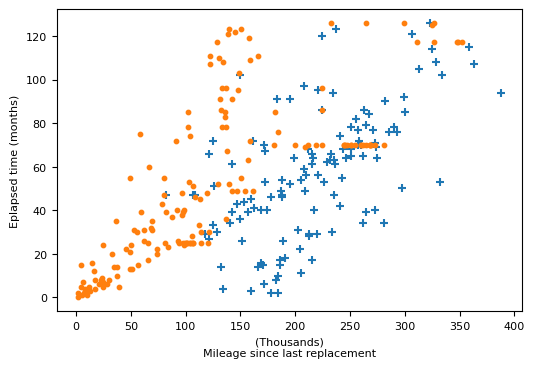

In [10]:
# Figure 1
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
ax = fig.add_subplot(111)

g_repl = data[data.repl==1].reset_index(drop=True)
g_main = data[data.repl==0].groupby("id").last().reset_index(drop=True)

g_repl.mileage = g_repl.mileage / 1000
g_main.mileage = g_main.mileage / 1000

ax.scatter(g_repl["mileage"], g_repl["period"], marker="+")
ax.scatter(g_main["mileage"], g_main["period"], s=10)

plt.ylabel("Eplapsed time (months)")
plt.xlabel("(Thousands)\nMileage since last replacement")
plt.show()